In [61]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from astropy.io import fits
from scipy.interpolate import interp1d # 线性插值
import matplotlib.pyplot as plt
from scipy.signal import medfilt # 中值滤波
from sklearn.preprocessing import StandardScaler  # 数据进行标准化
import json 
import shutil

In [2]:
# columns=['ASPCAP_Teff[K]', 'ASPCAP_Logg', 'ASPCAP_CH', 'ASPCAP_NH', 'ASPCAP_OH', 
#          'ASPCAP_MgH', 'ASPCAP_AlH', 'ASPCAP_SiH', 'ASPCAP_SH', 'ASPCAP_KH', 
#          'ASPCAP_CaH', 'ASPCAP_TiH', 'ASPCAP_CrH','ASPCAP_MnH', 'ASPCAP_FeH', 
#          'ASPCAP_NiH', 'lamost_snrg', 'lamost_obsid']

columns=['ASPCAP_Teff[K]', 'ASPCAP_Logg', 'ASPCAP_RV', 'ASPCAP_CH', 'ASPCAP_NH', 'ASPCAP_OH', 
         'ASPCAP_NaH', 'ASPCAP_MgH', 'ASPCAP_AlH', 'ASPCAP_SiH', 'ASPCAP_SH', 'ASPCAP_KH', 
         'ASPCAP_CaH', 'ASPCAP_TiH',  'ASPCAP_VH', 'ASPCAP_CrH','ASPCAP_MnH', 'ASPCAP_FeH', 
         'ASPCAP_NiH', 'snrg', 'obsid', 'uid',]

# 函数定义

## 工具函数：

### 遍历目录all_path：

功能描述

    函数遍历指定目录（包括其子目录）下的所有文件，并返回一个包含所有文件名的列表。

参数

    dirname (str): 需要遍历的目录路径字符串。
返回值

    返回一个列表，包含遍历得到的所有文件的名称（不包括路径）。

In [3]:
def all_path(dirname):
    files_names = []
    for maindir, subdir, file_name_list in os.walk(dirname):
        for filename in file_name_list:
            files_names.append(filename)
    return files_names

## 1.Wavelength Analysis 波长分析(wave_analyse)

wave_analyse 函数用于分析给定目录下的 FITS 文件中记录的天体光谱数据，计算并返回给定数据集中天体光谱的蓝端和红端波长范围的最小和最大值，同时考虑了红移的影响。

参数

    DATASET_PATH (str): 指向包含光谱数据概览的 CSV 文件的路径。该文件用于辅助分析，但本函数示例中未直接使用该参数。
    FITS_PATH (str): 包含 FITS 文件的目录路径。这些 FITS 文件包含了天体光谱数据。
返回值:四个浮点数，分别是：

    B_fact_min: 所有考察光谱中，蓝端波长的最小值。
    B_fact_max: 所有考察光谱中，蓝端波长的最大值。
    R_fact_min: 所有考察光谱中，红端波长的最小值。
    R_fact_max: 所有考察光谱中，红端波长的最大值。

In [4]:
# 定义一个函数，用于分析波长数据
def wave_analyse(DATASET_PATH, FITS_PATH):
    # 蓝端波长范围的最小和最大值
    B_wave_min = np.log10(3800)
    B_wave_max = np.log10(5700)

    # 红端波长范围的最小和最大值
    R_wave_min = np.log10(5900)
    R_wave_max = np.log10(8800)
    
    # 初始化存储蓝端和红端波长数据的列表
    B_wave = []
    R_wave = []
    label = []
    
    # 读取数据集路径下的CSV文件
    data = pd.read_csv(DATASET_PATH)  
    
    # 获取所有FITS文件的路径
    file_names = all_path(FITS_PATH)
    print(len(file_names))
    file_names = np.array(file_names)
    
    # 遍历每个FITS文件
    for i in tqdm(range(len(file_names))):
        try:  
            # 打开FITS文件
            f = fits.open(FITS_PATH + file_names[i])
            try:
                # 尝试获取第一个HDU的流量和波长数据
                F = f[0].data[0]  # 流量
                W = f[0].data[2]  # 波长
            except:
                # 如果第一个HDU中没有数据，则尝试从第二个HDU中获取
                F = f[1].data["FLUX"][0]
                W = f[1].data["WAVELENGTH"][0]
                
            # 获取红移值，并调整波长数据
            z = f[0].header['Z']  # 红移
            W = np.log10(W) - np.log10(1 + np.float64(z))
            # 根据蓝端和红端的波长范围，获取相应的波长数据
            B_W = (W > B_wave_min)*(W < B_wave_max)
            R_W = (W > R_wave_min)*(W < R_wave_max)
            # 添加蓝端波长数据
            B_wave.append(W[B_W])
            # 添加红端波长数据
            R_wave.append(W[R_W])
        except:
            # 处理异常情况，跳过当前循环
            print("Handling exceptions, skipped, indexed as : ", i)
            continue
    
    # 获取所有蓝端波长数据的最大和最小值
    B_fact_max = np.max(B_wave[0])
    B_fact_min = np.min(B_wave[0])
    for W in B_wave:
        try:
            B_fact_max = min(B_fact_max, np.max(W))
            B_fact_min = max(B_fact_min, np.min(W))
        except:
            continue
    
    # 获取所有红端波长数据的最大和最小值
    R_fact_max = np.max(R_wave[0])
    R_fact_min = np.min(R_wave[0])
    for W in R_wave:
        try:
            R_fact_max = min(R_fact_max, np.max(W))
            R_fact_min = max(R_fact_min, np.min(W))
        except:
            continue
    

    B_wave_scope = [B_fact_min, B_fact_max]
    R_wave_scope = [R_fact_min, R_fact_max]
    # 返回蓝端和红端波长的最小和最大值
    return B_wave_scope, R_wave_scope

# # 测试
# B_wave_scope, R_wave_scope = wave_analyse(DATASET_PATH, FITS_PATH)
# print(B_wave_scope, R_wave_scope)

In [5]:
# 定义一个函数，用于分析波长数据（去除了基于红移的波长矫正）
def wave_analyse(DATASET_PATH, FITS_PATH):
    # 蓝端波长范围的最小和最大值
    B_wave_min = np.log10(3800)
    B_wave_max = np.log10(5700)

    # 红端波长范围的最小和最大值
    R_wave_min = np.log10(5900)
    R_wave_max = np.log10(8800)
    
    # 初始化存储蓝端和红端波长数据的列表
    B_wave = []
    R_wave = []
    label = []
    
    # # 读取数据集路径下的CSV文件
    # data = pd.read_csv(DATASET_PATH)  
    
    # 获取所有FITS文件的路径
    file_names = all_path(FITS_PATH)
    print(len(file_names))
    file_names = np.array(file_names)
    
    # 遍历每个FITS文件
    for i in tqdm(range(len(file_names))):
        try:  
            # 打开FITS文件
            f = fits.open(FITS_PATH + file_names[i])
            try:
                # 尝试获取第一个HDU的流量和波长数据
                F = f[0].data[0]  # 流量
                W = f[0].data[2]  # 波长
            except:
                # 如果第一个HDU中没有数据，则尝试从第二个HDU中获取
                F = f[1].data["FLUX"][0]
                W = f[1].data["WAVELENGTH"][0]
                
            # 获取红移值，并调整波长数据
            # z = f[0].header['Z']  # 红移
            # W = np.log10(W) - np.log10(1 + np.float64(z))
            W = np.log10(W)
            
            
            # 根据蓝端和红端的波长范围，获取相应的波长数据
            B_W = (W > B_wave_min)*(W < B_wave_max)
            R_W = (W > R_wave_min)*(W < R_wave_max)
            # 添加蓝端波长数据
            B_wave.append(W[B_W])
            # 添加红端波长数据
            R_wave.append(W[R_W])
        except:
            # 处理异常情况，跳过当前循环
            print("Handling exceptions, skipped, indexed as : ", i)
            continue
    
    # 获取所有蓝端波长数据的最大和最小值
    B_fact_max = np.max(B_wave[0])
    B_fact_min = np.min(B_wave[0])
    for W in B_wave:
        try:
            B_fact_max = min(B_fact_max, np.max(W))
            B_fact_min = max(B_fact_min, np.min(W))
        except:
            continue
    
    # 获取所有红端波长数据的最大和最小值
    R_fact_max = np.max(R_wave[0])
    R_fact_min = np.min(R_wave[0])
    for W in R_wave:
        try:
            R_fact_max = min(R_fact_max, np.max(W))
            R_fact_min = max(R_fact_min, np.min(W))
        except:
            continue
    

    B_wave_scope = [B_fact_min, B_fact_max]
    R_wave_scope = [R_fact_min, R_fact_max]
    # 返回蓝端和红端波长的最小和最大值
    return B_wave_scope, R_wave_scope


# DATASET_PATH = r"./download/snrg_split_match_catalog/match_low_0_10.csv"
# FITS_PATH = r'./download/FITSDATA/test/'
# B_wave_scope, R_wave_scope = wave_analyse(DATASET_PATH, FITS_PATH)
# print(B_wave_scope, R_wave_scope)

## 2. 线性插值 (linear_inter)

In [6]:


# 定义一个函数进行线性插值
def linear_inter(DATASET_PATH, FITS_PATH, B_wave_scope, R_wave_scope):
    
    # 计算蓝端和红端波长范围的对数值
    B_wave_min = np.log10(3800)
    B_wave_max = np.log10(5700)

    R_wave_min = np.log10(5900)
    R_wave_max = np.log10(8800)
    
    # 读取CSV文件中的数据集
    # data = pd.read_csv(DATASET_PATH)  
    # 初始化存储蓝红波段流量数据的列表
    BR_flux_data = []
    # 初始化文件名列表
    file_names = []
    
    # 获取FITS文件的路径
    file_names = all_path(FITS_PATH)
    
    # 初始化错误列表
    error_list = []
    
    # 遍历文件名列表
    for i in tqdm(range(len(file_names))):
        try:
            # 打开FITS文件
            f = fits.open(FITS_PATH + file_names[i])
            
            try:
                # 尝试从第一个HDU获取流量和波长数据
                F = f[0].data[0] 
                W = f[0].data[2] 
            except:
                # 如果第一个HDU中没有数据，则从第二个HDU获取
                F = f[1].data["FLUX"][0]
                W = f[1].data["WAVELENGTH"][0]
            
            # 获取红移值并调整波长数据
            z = f[0].header['Z']  
            W = np.log10(W) - np.log10(1 + np.float64(z))
        
            # # 定义蓝端和红端波长范围
            # B_wave_scope = [B_fact_min, B_fact_max]
            # R_wave_scope = [R_fact_min, R_fact_max]
        
            # 获取蓝端的流量和波长数据
            B_flux = F[(W > B_wave_min)*(W < B_wave_max)]
            B_wave = W[(W > B_wave_min)*(W < B_wave_max)]
        
            # # 对全部数据进行线性插值
            # f = interp1d(W, F, kind = 'linear')
        
            # 获取红端的流量和波长数据
            R_flux = F[(W > R_wave_min)*(W < R_wave_max)]
            R_wave = W[(W > R_wave_min)*(W < R_wave_max)]
              
            # 分别对蓝端和红端的数据进行线性插值
            B_f = interp1d(B_wave, B_flux, kind = 'linear')
            R_f = interp1d(R_wave, R_flux, kind = 'linear')
        
            # 设置采样率为0.0001，并生成固定波长范围的蓝端和红端波长数组
            B_wave_fixed = np.arange(B_wave_scope[0], B_wave_scope[1], 0.0001)
            R_wave_fixed = np.arange(R_wave_scope[0], R_wave_scope[1], 0.0001)
        
            # 将插值后的蓝端和红端流量数据合并，并添加到列表中
            BR_flux_data.append(np.concatenate((B_f(B_wave_fixed), R_f(R_wave_fixed))))
        
        except:
            # 处理异常情况，跳过当前循环
            print("Handling exceptions, skipped, indexed as : ", i) 
            error_list.append(i)
            continue
    
    # 打印处理后的数据量和数据维度信息
    print("The magnitude of the traffic data on the common wavelength position obtained \
          after interpolation of the red and blue bands separately：", np.shape(BR_flux_data)[1])
    print("Number of processed data：", np.shape(BR_flux_data)[0])
        
    # 返回插值后的流量数据以及蓝端和红端的固定波长数组
    return BR_flux_data, B_wave_fixed, R_wave_fixed, error_list


In [7]:


# 定义一个函数进行线性插值（去除了基于红移的波长矫正）
def linear_inter(DATASET_PATH, FITS_PATH, B_wave_scope, R_wave_scope):
    
    # 计算蓝端和红端波长范围的对数值
    B_wave_min = np.log10(3800)
    B_wave_max = np.log10(5700)

    R_wave_min = np.log10(5900)
    R_wave_max = np.log10(8800)
    
    # 读取CSV文件中的数据集
    # data = pd.read_csv(DATASET_PATH)  
    # 初始化存储蓝红波段流量数据的列表
    BR_flux_data = []
    # 初始化文件名列表
    file_names = []
    
    # 获取FITS文件的路径
    file_names = all_path(FITS_PATH)
    
    # 初始化错误列表
    error_list = []
    
    # 遍历文件名列表
    for i in tqdm(range(len(file_names))):
        try:
            # 打开FITS文件
            f = fits.open(FITS_PATH + file_names[i])
            
            try:
                # 尝试从第一个HDU获取流量和波长数据
                F = f[0].data[0] 
                W = f[0].data[2] 
            except:
                # 如果第一个HDU中没有数据，则从第二个HDU获取
                F = f[1].data["FLUX"][0]
                W = f[1].data["WAVELENGTH"][0]
            
            # # 获取红移值并调整波长数据
            # z = f[0].header['Z']  
            # W = np.log10(W) - np.log10(1 + np.float64(z))
            W = np.log10(W)
        
            # # 定义蓝端和红端波长范围
            # B_wave_scope = [B_fact_min, B_fact_max]
            # R_wave_scope = [R_fact_min, R_fact_max]
        
            # 获取蓝端的流量和波长数据
            B_flux = F[(W > B_wave_min)*(W < B_wave_max)]
            B_wave = W[(W > B_wave_min)*(W < B_wave_max)]
        
            # # 对全部数据进行线性插值
            # f = interp1d(W, F, kind = 'linear')
        
            # 获取红端的流量和波长数据
            R_flux = F[(W > R_wave_min)*(W < R_wave_max)]
            R_wave = W[(W > R_wave_min)*(W < R_wave_max)]
              
            # 分别对蓝端和红端的数据进行线性插值
            B_f = interp1d(B_wave, B_flux, kind = 'linear')
            R_f = interp1d(R_wave, R_flux, kind = 'linear')
        
            # 设置采样率为0.0001，并生成固定波长范围的蓝端和红端波长数组
            B_wave_fixed = np.arange(B_wave_scope[0], B_wave_scope[1], 0.0001)
            R_wave_fixed = np.arange(R_wave_scope[0], R_wave_scope[1], 0.0001)
        
            # 将插值后的蓝端和红端流量数据合并，并添加到列表中
            BR_flux_data.append(np.concatenate((B_f(B_wave_fixed), R_f(R_wave_fixed))))
        
        except:
            # 处理异常情况，跳过当前循环
            print("Handling exceptions, skipped, indexed as : ", i) 
            error_list.append(i)
            continue
    
    # 打印处理后的数据量和数据维度信息
    print("The magnitude of the traffic data on the common wavelength position obtained \
          after interpolation of the red and blue bands separately：", np.shape(BR_flux_data)[1])
    print("Number of processed data：", np.shape(BR_flux_data)[0])
        
    # 返回插值后的流量数据以及蓝端和红端的固定波长数组
    return BR_flux_data, B_wave_fixed, R_wave_fixed, error_list


## 3. 连续谱拟合和归一化处理 (normalization_by_polyfit)

### csp_polyfit：  多项式拟合

csp_polyfit：归一化光谱和波长，拟合出一个多项式

参数说明：

    sp: 光流量数据，一维数组。
    angs: 角度数据，一维数组，应与光流量数据在长度上匹配。
    param：
        poly_global_order: 多项式拟合的全局阶数。
        poly_upperlimit和poly_lowerlimit: 用于数据点选择的标准差倍数阈值。
        poly_del_filled: 指示如何处理不符合条件的数据点，1 表示删除，其它值表示用拟合值填充。
    
返回值：

    param：
        poly_sp_c、poly_sp_s、poly_angs_c和poly_angs_s: 分别保存流量和波长的平均值、标准差
        poly_P_g: 拟合过程中计算的多项式系数。
        poly_sp_filtered和poly_angs_filtered: 过滤后的光流量和角度数据。

In [8]:
def csp_polyfit(sp, angs, param):
    # 标准化光流量
    sp_c = np.mean(sp)   # 计算光流量的平均值，即中位流量
    sp = sp - sp_c           # 以平均值为中心调整光流量，实现光流量的中心化
    sp_s = np.std(sp)     # 计算光流量的标准差，即流量均方差
    sp = sp / sp_s        # 用标准差标准化光流量
    
    # 标准化角度
    angs_c = np.mean(angs)  # 计算波长的平均值
    angs = angs - angs_c    # 以平均值为中心调整角度
    angs_s = np.std(angs)   # 计算波长的标准差
    angs = angs / angs_s    # 用标准差标准化波长
    
    # 更新参数字典
    param['poly_sp_c'] = sp_c
    param['poly_sp_s'] = sp_s
    param['poly_angs_c'] = angs_c
    param['poly_angs_s'] = angs_s
    
    # 初始化数据标志
    data_flag = np.full(sp.shape, 1)
    
    i = 0
    con = True
    while(con):
        # 使用多项式拟合并获取系数
        P_g = np.polyfit(angs, sp, param['poly_global_order'])  # 计算多项式系数
        param['poly_P_g'] = P_g
        fitval_1 = np.polyval(P_g, angs)   # 计算多项式的拟合值
        dev = fitval_1 - sp  # 计算拟合值与实际值的偏差
        sig_g = np.std(dev)  # 计算偏差的标准差
        
        # 更新数据标志，用于识别需要保留的数据点
        data_flag_new = (dev > (-param['poly_upperlimit'] * sig_g)) * (dev < (param['poly_lowerlimit'] * sig_g))
    
        if sum(abs(data_flag_new - data_flag)) > 0:
            if param['poly_del_filled'] == 1: 
                data_flag = data_flag_new  # 更新数据标志
            else:
                fill_flag = data_flag - data_flag_new  # 计算需要填充的数据标志
                index_1 = np.where(fill_flag != 0)  # 找出需要填充的数据点
                sp[index_1] = fitval_1[index_1]  # 用拟合值填充这些数据点
        else:
            con = False  # 如果数据标志没有变化，则停止迭代
        i += 1
    #     print("iteration is %d" %i)  # 打印迭代次数，此行为调试用，通常被注释
    
    # 根据最终的数据标志筛选数据
    index_2 = np.where(data_flag != 0)
    param['poly_sp_filtered'] = sp[index_2]  # 更新参数字典，保存过滤后的光流量数据
    param['poly_angs_filtered'] = angs[index_2]  # 更新参数字典，保存过滤后的角度数据
    
    return param  # 返回更新后的参数字典


### sp_median_polyfit1stage： 连续谱拟合

对一条光谱进行一系列处理最终获得一个拟合连续谱。具体操作包括：1.用中值滤波结果预剔除异常数据点 2.拟合一个归一化后的多项式 3.反归一化得到最终拟合连续谱

使用说明

    sp_median_polyfit1stage(flux, lambda_log, param)
参数

    flux: 光通量数据，一维数组。
    lambda_log: 对数波长数据，与光通量数据相对应的一维数组。
    param: 参数字典，包含处理过程中需要的各种参数。
参数字典param的关键字段

    median_radius: 中值滤波的窗口半径。
    poly_lowerlimit: 多项式拟合预剔除下限，乘以标准差作为阈值。
    poly_upperlimit: 多项式拟合预剔除上限，乘以标准差作为阈值。
    poly_del_filled: 处理标记为填充的数据点的方法（1表示删除这些点，2表示用中值滤波结果填充）。
    poly_angs_c, poly_angs_s: 波长预处理中的中心化和缩放参数。
    poly_P_g: 连续谱拟合的多项式系数。
    poly_sp_s, poly_sp_c: 连续谱拟合后的缩放和偏移参数。
    poly_SM: 是否使用原始波长（1）或对数波长（其它值）。
返回值

    continum_fitted: 拟合的连续谱，一维数组，与输入的光通量数据对应。

In [9]:
def sp_median_polyfit1stage(flux, lambda_log,param):
    flux1 = flux  # 复制光通量数据
    lambda1 = lambda_log  # 复制对数波长数据

    # 中值滤波
    flux_median1 = medfilt(flux1, param['median_radius'])  # 使用中值滤波处理光通量数据

    # 利用中值滤波结果进行预剔除
    dev1 = flux_median1 - flux1  # 计算中值滤波后的光通量与原光通量的差值
    sigma = np.std(dev1)  # 计算差值的标准差
    # 生成数据标记，用于识别符合预剔除条件的数据点
    data_flag1 = (dev1 < (param['poly_lowerlimit'] * sigma)) * (dev1 > (-param['poly_upperlimit'] * sigma))
    
    # 利用中值滤波结果进行伪光谱线的预剔除
    fill_flag1 = 1 - data_flag1  # 生成填充标记，用于识别需要被填充的数据点
    
    # 根据参数决定如何处理填充标记指示的数据点
    if param['poly_del_filled'] == 1:
        index_1 = np.where(data_flag1)  # 找到符合条件的数据点索引
        flux1 = flux1[index_1]  # 仅保留这些数据点的光通量数据
        lambda1 = lambda1[index_1]  # 仅保留这些数据点的波长数据
    elif param['poly_del_filled'] == 2:
        index_2 = np.where(fill_flag1)  # 找到需要填充的数据点索引
        flux1[index_2] = flux_median1[index_2]  # 用中值滤波结果填充这些数据点的光通量
        
    # 迭代拟合连续谱
    param = csp_polyfit(flux1, lambda1, param)  # 执行连续谱的多项式拟合
    
    # 波长预处理
    angs = lambda1 - param['poly_angs_c']  # 波长中心化
    angs = angs / param['poly_angs_s']  # 波长缩放
    
    # 连续谱样本
    fitval_g = np.polyval(param['poly_P_g'], angs)  # 使用多项式系数计算连续谱的拟合值
    continum_fitted = fitval_g * param['poly_sp_s'] + param['poly_sp_c']  # 根据参数调整连续谱的拟合值
    
    # 根据参数选择使用原始波长或对数波长
    if param['poly_SM'] == 1: 
        angss = lambda1
    else: 
        angss = 10 ** lambda1  # 如果需要，将波长转换为对数形式
 
    return continum_fitted  # 返回拟合的连续谱

### normalization_by_polyfit： 使用拟合连续谱对原始光谱数据归一化

概述
对每条光谱的蓝端和红端分别进行连续谱拟合和归一化。先分别处理蓝端和红端的光谱，对每一部分分别进行连续谱拟合，最后利用拟合结果对原始光谱数据进行归一化处理。

参数说明

    BR_flux_data: 原始光谱数据数组，假设为二维数组，其中每一行代表一条光谱数据。
    B_wave_fixed: 蓝端波长的固定采样数组，一维数组。
    R_wave_fixed: 红端波长的固定采样数组，一维数组。
    param: (可选) 拟合参数字典，用于控制连续谱拟合的具体行为。如果未提供，则使用默认参数。
    SAVE_PATH: (可选) 字符串，表示保存处理后数据的文件路径。如果提供此参数，函数将处理后的数据保存为NumPy文件。
返回值

    BR_flux_data_fitted: 归一化后的光谱数据数组，与原始光谱数据具有相同的形状。

In [10]:
def normalization_by_polyfit(BR_flux_data, B_wave_fixed, R_wave_fixed, param=None, SAVE_PATH=None):
    """
    对光谱数据进行连续谱拟合和归一化处理。

    参数:
    - BR_flux_data: 原始光谱数据数组。
    - B_wave_fixed: 蓝端波长的固定采样数组。
    - R_wave_fixed: 红端波长的固定采样数组。
    - param: 拟合参数字典，可选。
    - SAVE_PATH: 保存处理后数据的文件路径，可选。
    """
    # 检查是否提供了拟合参数，如果没有，则设置默认参数
    if param is None:
        param = {'poly_global_order': 5, 'nor': 1, 'poly_lowerlimit': 3, 'poly_upperlimit': 4, 
                 'median_radius': 3, 'poly_SM': 0, 'poly_del_filled': 2}

    # 初始化一个与原始光谱数据相同形状的数组，用于存储拟合后的数据
    BR_flux_data_fitted = np.zeros_like(BR_flux_data)
    
    # 遍历每一行光谱数据
    for i in tqdm(range(BR_flux_data_fitted.shape[0])):
        
        try:
            # 对蓝端和红端波长的光谱数据分别进行连续谱拟合
            B_continum_fitted_train = sp_median_polyfit1stage(BR_flux_data[i][:len(B_wave_fixed)], np.log10(B_wave_fixed), param)
            R_continum_fitted_train = sp_median_polyfit1stage(BR_flux_data[i][len(B_wave_fixed):], np.log10(R_wave_fixed), param)

            # 使用拟合得到的连续谱对原始光谱数据进行归一化
            BR_flux_data_fitted[i, :len(B_wave_fixed)] = BR_flux_data[i][:len(B_wave_fixed)] / B_continum_fitted_train
            BR_flux_data_fitted[i, len(B_wave_fixed):] = BR_flux_data[i][len(B_wave_fixed):] / R_continum_fitted_train
        except:
            print(f"Handling exceptions, indexed as: {i}")
            continue

    # 如果提供了保存路径，将处理后的数据保存到指定文件
    if SAVE_PATH:
        np.save(SAVE_PATH, BR_flux_data_fitted)
    
    return BR_flux_data_fitted

# 注意: sp_median_polyfit1stage 需要根据实际的函数定义和参数进行调整。

## 4. 用3σ原则处理异常值和标准化处理

### three_sigma：异常值处理子函数

函数基于3σ原则（三西格玛规则）对光谱数据中的异常值进行识别和处理。先假设数据遵循正态分布，数据集中在均值的±3σ（标准差）区间内的概率为99.73%，因此位于这个区间之外的点被视为异常值。该函数计算给定光谱数据片段的平均值和标准差，识别异常值，并将这些异常值替换为平均值，最后返回处理后的光谱数据点列表。

In [11]:
def three_sigma(Flux, flux_index, sigma_rate=3):
    mean_value = Flux[flux_index].mean()  # 计算指定索引光谱数据的平均值
    std_value = Flux[flux_index].std()  # 计算指定索引光谱数据的标准差
    # 根据3σ原则确定异常值规则：异常值为超出平均值±3倍标准差的数据点
    rule = (mean_value - sigma_rate * std_value > Flux[flux_index]) | (mean_value + sigma_rate * std_value < Flux[flux_index])
    indice = np.arange(Flux[flux_index].shape[0])[rule]  # 获取所有异常值的索引位置
    Flux_points = []  # 初始化一个列表，用于存放处理后的光谱数据点
    for i in range(Flux[flux_index].shape[0]):  # 遍历光谱数据点
        if i in indice:  # 如果当前点是异常值
            Flux_points.append(mean_value)  # 用平均值替换异常值
        else:
            Flux_points.append(Flux[flux_index][i])  # 正常值保持不变
    return Flux_points  # 返回处理后的光谱数据点列表


### three_sigma_processing：

用于批量处理光谱数据集，应用3σ原则去除异常值并进行后续的标准化处理。

In [12]:
def three_sigma_processing(Flux, SAVE_PATH_3sigma=None):
    Flux_3sigma = []  # 初始化一个列表，用于存储所有光谱数据的3σ处理结果
    for i in tqdm(range(Flux.shape[0])):  # 遍历所有光谱数据
        Flux_3sigma.append(three_sigma(Flux, i, sigma_rate=3))  # 对每条光谱数据应用3σ处理
    Flux_3sigma = np.array(Flux_3sigma)  # 将处理结果列表转换为NumPy数组
    sc = StandardScaler()  # 创建一个StandardScaler对象，用于后续的标准化处理
    Flux_3sigma_sc_T = sc.fit_transform(Flux_3sigma.T)  # 对3σ处理后的光谱数据进行标准化
    Flux_3sigma_sc = Flux_3sigma_sc_T.T  # 转置回原来的形状
    if SAVE_PATH_3sigma:
        np.save(SAVE_PATH_3sigma, Flux_3sigma_sc)  # 将标准化后的光谱数据保存到指定路径
    return  Flux_3sigma_sc


## 5. Matching spectra and tagging 匹配光谱和标记

In [13]:
def match_and_labeling_apogee(labels_list, match_path, FITS_PATH, LABEL_PATH, failed_indice):
        # 从DATASET_PATH读取数据集
        data = pd.read_csv(match_path)
        label_all = []  # 初始化标签列表
        file_names = all_path(FITS_PATH)  # 获取FITS_PATH下的所有文件路径
        file_names = np.array(file_names)  # 将文件名列表转换为numpy数组
        
        # 存储未找到对应FITS文件的恒星的obsid
        obsid_list = []

        # 生成文件名的索引数组
        file_names_indice = np.arange(file_names.shape[0])
        # 从索引数组中移除失败的索引
        file_names_indice = np.setdiff1d(file_names_indice, failed_indice, assume_unique=True)
        # 使用剩余的索引更新文件名数组
        file_names = file_names[file_names_indice]
        
        for name in tqdm(file_names):  # 进度条显示处理进度
            try:
                f = fits.open(FITS_PATH + name)  # 打开FITS文件
                obsid = f[0].header['OBSID']  # 从文件头部读取OBSID
                lables_values = []  # 初始化标签值列表
                for label_name in labels_list:  # 遍历所有标签名称
                    # 根据OBSID和标签名称获取标签值
                    label_value = data.loc[data.obsid == obsid][label_name].values
                    lables_values.append(label_value)  # 将标签值添加到列表中
                label_all.append(lables_values)  # 将标签值列表添加到总列表中
            except:
                obsid_list.append(obsid)  # 如果出错，则将OBSID添加到未找到列表中
                continue
        label_all = np.asarray(label_all)  # 将标签列表转换为numpy数组
        np.save(LABEL_PATH, label_all)  # 将标签数组保存到LABEL_PATH指定的路径
        print(obsid_list)
        return label_all
    
    
# match_path = "./download/snrg_split_match_catalog/match_50_100.csv"
# FITS_PATH =  "./download/FITSDATA/50_100/"
# LABEL_PATH = "./data_after_processing/Labels/50_100"

# with open('./failed_indice_dir.json', "r") as file:
#     failed_indices = json.load(file)
    
# failed_indice = failed_indices["./data_after_processing/Flux/50_100.npy"]
# label_all=match_and_labeling_apogee(columns, match_path, FITS_PATH, LABEL_PATH, failed_indice)    

# 处理流程：

### 整体流程：

In [23]:
DATASET_PATH = r"E:\my_star\download\snrg_split\match_low_0_10.csv"
FITS_PATH = r'E:\my_star\FITSDATA\low_0_10/'
SAVE_PATH_low = r"E:\my_star\data_after_processing\Flux_low\0_10.npy"
SAVE_PATH_high = r"E:\my_star\data_after_processing\Flux_high\0_10.npy"

# 1.初步波长分析，计算光谱蓝端和红端波长范围的最小和最大值
B_wave_scope, R_wave_scope = wave_analyse(DATASET_PATH, FITS_PATH)

# 2.在范围内进行插值，统一波长范围和数据格式
BR_flux_data, B_wave_fixed, R_wave_fixed,failed_indice = linear_inter(DATASET_PATH, FITS_PATH, B_wave_scope, R_wave_scope)

# 3.进行连续谱拟合，并以此对原始光谱数据归一化
BR_flux_data_fitted = normalization_by_polyfit(BR_flux_data, B_wave_fixed, R_wave_fixed, param=None, SAVE_PATH=None)

# # 4.基于3σ原则对光谱数据中的异常值进行识别和处理，并归一化
Flux_3sigma_sc=three_sigma_processing(BR_flux_data_fitted,SAVE_PATH_low)

# # 标签匹配
# label_all=match_and_labeling_apogee(columns, match_path, FITS_PATH, LABEL_PATH, failed_indice)    

34938


 12%|█████████▏                                                                  | 4251/34938 [00:20<02:29, 205.68it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_15524\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 34938/34938 [02:54<00:00, 199.68it/s]


### 详细过程：

#### 定义数据的路径

In [28]:
# 定义数据的路径

DATASET_PATH = "./download/snrg_split_match_catalog/match_50_100.csv"
FITS_PATH = "./download/FITSDATA/50_100/"
SAVE_PATH = "./data_after_processing/Labels"
Labels_SAVE_PATH = "./data_after_processing/Labels"

#### 1.初步波长分析，计算光谱蓝端和红端波长范围的最小和最大值

In [19]:
# 1.初步波长分析，计算光谱蓝端和红端波长范围的最小和最大值
B_wave_scope, R_wave_scope = wave_analyse(DATASET_PATH, FITS_PATH)

57703


  7%|████▉                                                                       | 3774/57703 [00:17<04:09, 215.72it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_5140\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 57703/57703 [05:17<00:00, 181.70it/s]


In [21]:
B_wave_scope

[3.5845802, 3.7557747]

In [45]:
B_wave_scope 

[3.5845432, 3.641482]

In [56]:
R_wave_scope

[3.7709522, 3.9443824]

In [46]:
R_wave_scope

[3.7709522, 3.9443824]

In [26]:
# 读取数据集路径下的CSV文件
data = pd.read_csv(DATASET_PATH)  
data.shape

(34978, 22)

#### 2.在范围内进行插值，统一波长范围和数据格式

In [23]:
# 2.在范围内进行插值，统一波长范围和数据格式
BR_flux_data, B_wave_fixed, R_wave_fixed,failed_indice = linear_inter(DATASET_PATH, FITS_PATH, B_wave_scope, R_wave_scope)

 12%|█████████▏                                                                  | 4252/34938 [00:29<03:59, 127.90it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_5140\1721443507.py:41: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
 12%|█████████▎                                                                  | 4279/34938 [00:29<04:11, 122.10it/s]

Handling exceptions, skipped, indexed as :  4262


 31%|███████████████████████▍                                                   | 10895/34938 [01:15<02:39, 150.93it/s]

Handling exceptions, skipped, indexed as :  10865


 52%|███████████████████████████████████████                                    | 18209/34938 [02:11<02:04, 134.39it/s]

Handling exceptions, skipped, indexed as :  18196


 57%|██████████████████████████████████████████▌                                | 19834/34938 [02:24<01:56, 129.23it/s]

Handling exceptions, skipped, indexed as :  19817


 61%|█████████████████████████████████████████████▌                             | 21241/34938 [02:34<01:38, 139.65it/s]

Handling exceptions, skipped, indexed as :  21225


 66%|█████████████████████████████████████████████████▍                         | 23029/34938 [02:48<01:32, 128.37it/s]

Handling exceptions, skipped, indexed as :  23004


 66%|█████████████████████████████████████████████████▊                         | 23233/34938 [02:49<01:25, 137.54it/s]

Handling exceptions, skipped, indexed as :  23219


 67%|██████████████████████████████████████████████████                         | 23304/34938 [02:50<01:29, 130.33it/s]

Handling exceptions, skipped, indexed as :  23283


 74%|███████████████████████████████████████████████████████▌                   | 25888/34938 [03:10<01:14, 121.65it/s]

Handling exceptions, skipped, indexed as :  25870


 78%|██████████████████████████████████████████████████████████▎                | 27149/34938 [03:19<01:07, 115.00it/s]

Handling exceptions, skipped, indexed as :  27134


 84%|██████████████████████████████████████████████████████████████▋            | 29190/34938 [03:35<00:43, 132.09it/s]

Handling exceptions, skipped, indexed as :  29171


 97%|████████████████████████████████████████████████████████████████████████▊  | 33918/34938 [04:12<00:07, 135.81it/s]

Handling exceptions, skipped, indexed as :  33896


 98%|█████████████████████████████████████████████████████████████████████████▊ | 34377/34938 [04:15<00:04, 126.43it/s]

Handling exceptions, skipped, indexed as :  34355


100%|███████████████████████████████████████████████████████████████████████████| 34938/34938 [04:20<00:00, 134.15it/s]


The magnitude of the traffic data on the common wavelength position obtained           after interpolation of the red and blue bands separately： 3447
Number of processed data： 34925


In [38]:
len(BR_flux_data)

34925

In [58]:
len(BR_flux_data[5])

2305

In [42]:
B_wave_scope

[3.5845432, 3.641482]

In [43]:
R_wave_scope

[3.7709522, 3.9443824]

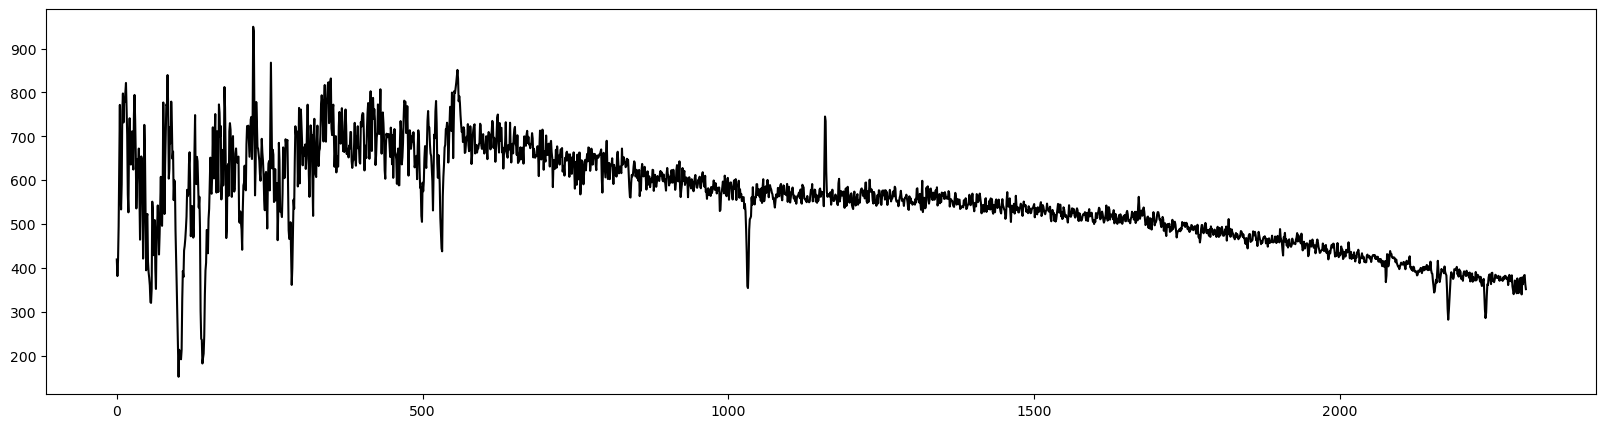

In [59]:
# 显示目前的效果
BR_flux_data[0]
plt.figure(figsize=[20, 5])
plt.plot(BR_flux_data[20], 'k-')

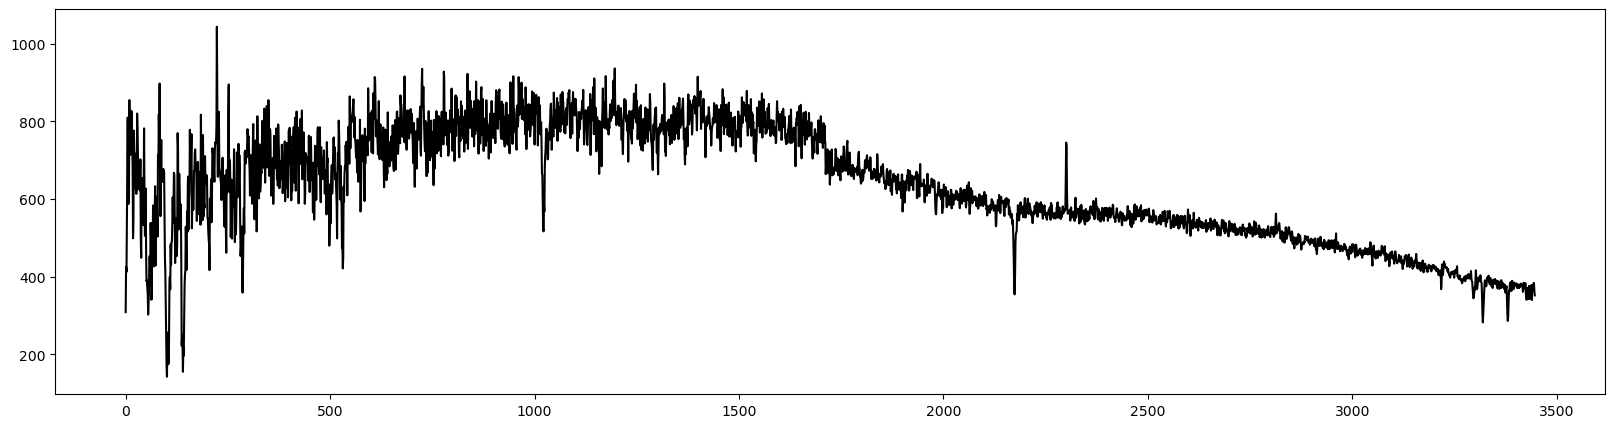

In [25]:
# 显示目前的效果
BR_flux_data[0]
plt.figure(figsize=[20, 5])
plt.plot(BR_flux_data[20], 'k-')

#### 3.进行连续谱拟合，并以此对原始光谱数据归一化

In [24]:
# 3.进行连续谱拟合，并以此对原始光谱数据归一化
BR_flux_data_fitted = normalization_by_polyfit(BR_flux_data, B_wave_fixed, R_wave_fixed, param=None, SAVE_PATH=None)

100%|███████████████████████████████████████████████████████████████████████████| 34925/34925 [04:29<00:00, 129.53it/s]


In [63]:
len(BR_flux_data_fitted)

34925

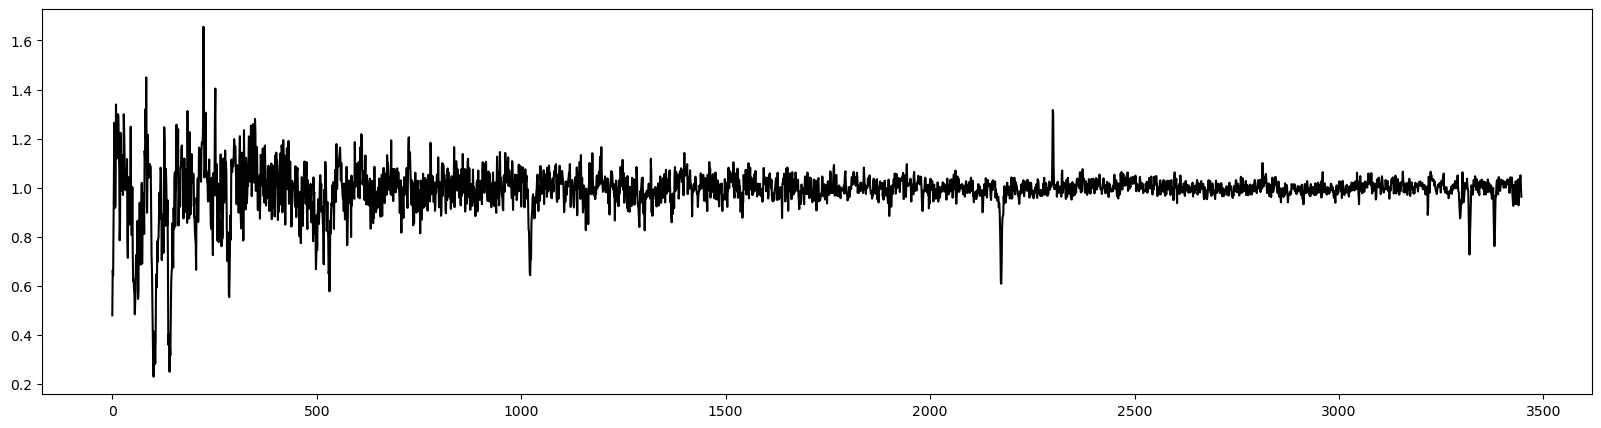

In [26]:
# 显示目前的效果
plt.figure(figsize=[20, 5])
plt.plot(BR_flux_data_fitted[20], 'k-')

#### 4.基于3σ原则对光谱数据中的异常值进行识别和处理，并归一化

In [29]:
Flux_3sigma_sc=three_sigma_processing(BR_flux_data_fitted,SAVE_PATH_low)

100%|███████████████████████████████████████████████████████████████████████████| 34925/34925 [05:29<00:00, 105.86it/s]


In [30]:
len(Flux_3sigma_sc)

13223

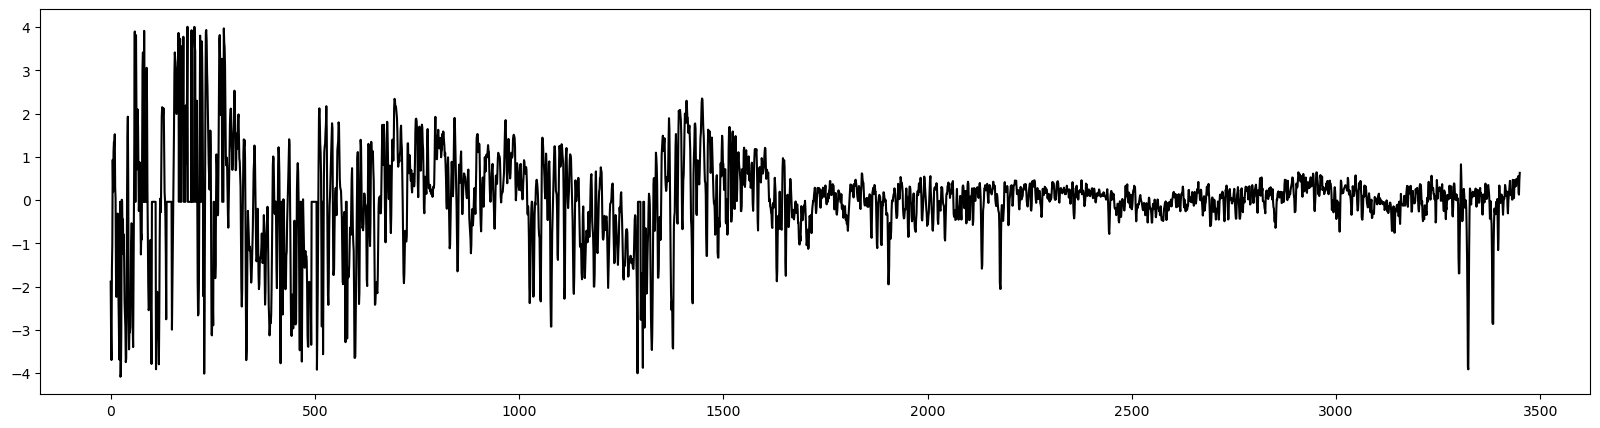

In [31]:
# 显示目前的效果
plt.figure(figsize=[20, 5])
plt.plot(Flux_3sigma_sc[20], 'k-')

#### 5.标签匹配

In [19]:
# Label Matching 标签匹配¶

# labels_list=['ASPCAP_Teff[K]', 'ASPCAP_Logg', 'ASPCAP_CH', 'ASPCAP_NH', 'ASPCAP_OH', 
#          'ASPCAP_MgH', 'ASPCAP_AlH', 'ASPCAP_SiH', 'ASPCAP_SH', 'ASPCAP_KH', 
#          'ASPCAP_CaH', 'ASPCAP_TiH', 'ASPCAP_CrH','ASPCAP_MnH', 'ASPCAP_FeH', 
#          'ASPCAP_NiH','lamost_snrg']
label_all=match_and_labeling_apogee(columns, DATASET_PATH, FITS_PATH, LABEL_PATH, failed_indice)
# label_all=match_and_labeling_apogee(columns, match_path, FITS_PATH, LABEL_PATH, failed_indice)  

100%|███████████████████████████████████████████████████████████████████████████| 13223/13223 [00:54<00:00, 242.77it/s]


[]


In [22]:
label_all[20]

array([[5.02571000e+03],
       [4.52551600e+00],
       [2.03818990e-01],
       [3.86489990e-01],
       [1.56726896e-01],
       [2.18442500e-01],
       [2.98096000e-01],
       [2.05053985e-01],
       [1.18396490e-01],
       [1.10356897e-01],
       [1.31684990e-01],
       [2.71178990e-01],
       [2.37268280e-01],
       [2.95312520e-01],
       [1.64030000e-01],
       [2.43670000e-01],
       [8.57700000e+01]])

In [74]:
data.columns

Index(['Unnamed: 0', 'ASPCAP_starid', 'ASPCAP_RA', 'ASPCAP_Dec', 'ASPCAP_RV',
       'ASPCAP_Teff[K]', 'ASPCAP_Logg', 'ASPCAP_CH', 'ASPCAP_NH', 'ASPCAP_OH',
       'ASPCAP_MgH', 'ASPCAP_AlH', 'ASPCAP_SiH', 'ASPCAP_SH', 'ASPCAP_KH',
       'ASPCAP_CaH', 'ASPCAP_TiH', 'ASPCAP_CrH', 'ASPCAP_MnH', 'ASPCAP_FeH',
       'ASPCAP_NiH', 'lamost_obsid', 'lamost_snrg', 'lamost_class',
       'lamost_subclass', 'lamost_z', 'lamost_ra', 'lamost_dec', 'lamost_logg',
       'lamost_file', 'GroupID', 'GroupSize', 'Separation'],
      dtype='object')

In [75]:
for name in tqdm(file_names):  # 进度条显示处理进度
            
    f = fits.open(FITS_PATH + name)  # 打开FITS文件
    obsid = f[0].header['OBSID']  # 从文件头部读取OBSID
    lables_values = []  # 初始化标签值列表
    for label_name in labels_list:  # 遍历所有标签名称
        # 根据OBSID和标签名称获取标签值
        label_value = data.loc[data.lamost_obsid == obsid][label_name].values
        lables_values.append(label_value)  # 将标签值添加到列表中
    label_all.append(lables_values)  # 将标签值列表添加到总列表中
            
        

100%|████████████████████████████████████████████████████████████| 13223/13223 [00:53<00:00, 246.81it/s]


In [ ]:
label_all

# 预处理打包处理：

### 定义打包函数

In [14]:

# columns=['ASPCAP_Teff[K]', 'ASPCAP_Logg', 'ASPCAP_RV', 'ASPCAP_CH', 'ASPCAP_NH', 'ASPCAP_OH', 
#          'ASPCAP_NaH', 'ASPCAP_MgH', 'ASPCAP_AlH', 'ASPCAP_SiH', 'ASPCAP_SH', 'ASPCAP_KH', 
#          'ASPCAP_CaH', 'ASPCAP_TiH',  'ASPCAP_VH', 'ASPCAP_CrH','ASPCAP_MnH', 'ASPCAP_FeH', 
#          'ASPCAP_NiH', 'snrg', 'obsid', 'uid',]

def data_processing(DATASET_PATH, FITS_PATH, LABEL_SAVE_PATH, SAVE_PATH, B_wave_scope, R_wave_scope):
    
    
    # 2.在范围内进行插值，统一波长范围和数据格式
    BR_flux_data, B_wave_fixed, R_wave_fixed,failed_indice = linear_inter(DATASET_PATH, FITS_PATH, B_wave_scope, R_wave_scope)

    # 3.进行连续谱拟合，并以此对原始光谱数据归一化
    BR_flux_data_fitted = normalization_by_polyfit(BR_flux_data, B_wave_fixed, R_wave_fixed, param=None, SAVE_PATH=None)

    # # 4.基于3σ原则对光谱数据中的异常值进行识别和处理，并归一化
    Flux_3sigma_sc=three_sigma_processing(BR_flux_data_fitted,SAVE_PATH)
    
    # 5.匹配恒星参数标签
    label_all=match_and_labeling_apogee(columns, DATASET_PATH, FITS_PATH, LABEL_SAVE_PATH, failed_indice)   
    
    return failed_indice

### 处理所有数据：

#### 1. 计算所有数据的波长范围
可以直接读取范围文件

In [17]:
# DATASET_PATH = r"E:\my_star\download\snrg_split\match_low_0_10.csv"
# FITS_PATH = r'E:\my_star\FITSDATA\low_0_10/'
# SAVE_PATH_low = r"E:\my_star\data_after_processing\Flux_low\0_10.npy"
# SAVE_PATH_high = r"E:\my_star\data_after_processing\Flux_high\0_10.npy"



# 定义列表存放没组数据的范围
B_wave_scope_list=[]
R_wave_scope_list=[]


# 依次计算low_0_10 —— 40_50 十个分组的范围
for i in range(5):
    # print(DATASET_PATH)
    
    DATASET_PATH = r"E:\my_star\download\snrg_split\match_low_{}_{}.csv".format(i*10,i*10+10)
    FITS_PATH =  r"E:\my_star\FITSDATA\low_{}_{}/".format(i*10,i*10+10)
    SAVE_PATH_low = r"E:\my_star\data_after_processing\Flux_low\{}_{}.npy".format(i*10,i*10+10)

    
    print(FITS_PATH)
    B_wave_temp_scope, R_wave_temp_scope = wave_analyse(DATASET_PATH, FITS_PATH)
    B_wave_scope_list.append(B_wave_temp_scope)
    R_wave_scope_list.append(R_wave_temp_scope)
    print(B_wave_temp_scope,R_wave_temp_scope)

    
# 计算high_100_120，high_120_200分组的范围
DATASET_PATH = r"E:\my_star\download\snrg_split\match_high_100_120.csv"
FITS_PATH =  r"E:\my_star\FITSDATA\high_100_120/"
SAVE_PATH_high = r"E:\my_star\data_after_processing\Flux_high\0_10.npy"
B_wave_temp_scope, R_wave_temp_scope = wave_analyse(DATASET_PATH, FITS_PATH)    
B_wave_scope_list.append(B_wave_temp_scope)
R_wave_scope_list.append(R_wave_temp_scope)

DATASET_PATH = r"E:\my_star\download\snrg_split\match_high_120_200.csv"
FITS_PATH =  r"E:\my_star\FITSDATA\high_120_200/"
SAVE_PATH_high = r"E:\my_star\data_after_processing\Flux_high\0_10.npy"
B_wave_temp_scope, R_wave_temp_scope = wave_analyse(DATASET_PATH, FITS_PATH)    
B_wave_scope_list.append(B_wave_temp_scope)
R_wave_scope_list.append(R_wave_temp_scope)



# 计算总范围    
B_wave_scope = [min(range[0] for range in B_wave_scope_list), max(range[1] for range in B_wave_scope_list)]
R_wave_scope = [min(range[0] for range in R_wave_scope_list), max(range[1] for range in R_wave_scope_list)]

E:\my_star\FITSDATA\low_0_10/
34938


 12%|█████████▎                                                                  | 4262/34938 [00:19<02:20, 218.06it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_16444\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 34938/34938 [02:35<00:00, 225.37it/s]


[3.5845432, 3.641482] [3.7709522, 3.9443824]
E:\my_star\FITSDATA\low_10_20/
57703


  7%|████▉                                                                       | 3765/57703 [00:16<04:01, 223.79it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_16444\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 57703/57703 [04:24<00:00, 217.84it/s]


[3.5845802, 3.7557747] [3.7709522, 3.9443824]
E:\my_star\FITSDATA\low_20_30/
53509


 14%|██████████▊                                                                 | 7650/53509 [00:35<03:31, 216.45it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_16444\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 53509/53509 [04:08<00:00, 215.22it/s]


[3.584718, 3.7557747] [3.7709522, 3.9443824]
E:\my_star\FITSDATA\low_30_40/
54145


 29%|█████████████████████▋                                                     | 15623/54145 [01:14<03:02, 211.17it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_16444\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 54145/54145 [04:17<00:00, 209.97it/s]


[3.584429, 3.7557747] [3.7709522, 3.9443824]
E:\my_star\FITSDATA\low_40_50/
56304


  1%|▊                                                                            | 588/56304 [00:02<04:17, 216.50it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_16444\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 56304/56304 [04:40<00:00, 200.74it/s]


[3.5843618, 3.7557747] [3.7709522, 3.9443824]
69028


  7%|█████▍                                                                      | 4976/69028 [00:23<04:55, 217.08it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_16444\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 69028/69028 [05:28<00:00, 209.82it/s]


78758


 10%|███████▍                                                                    | 7716/78758 [00:36<05:38, 209.85it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_16444\3616475048.py:40: RuntimeWarning: invalid value encountered in log10
  W = np.log10(W) - np.log10(1 + np.float64(z))
100%|███████████████████████████████████████████████████████████████████████████| 78758/78758 [06:16<00:00, 209.15it/s]


In [25]:
# 暂存计算的 wave_scope
wave_scope = {}
wave_scope['B_wave_scope']= [float(value) for value in B_wave_scope]
wave_scope['R_wave_scope']= [float(value) for value in R_wave_scope]
wave_scope_path = "./wave_scope.json"
with open(wave_scope_path, "w") as file:
    json.dump(wave_scope, file)

In [15]:
# 读取暂存的 wave_scope
wave_scope_path = "./wave_scope.json"
with open(wave_scope_path, "r") as file:
    wave_scope = json.load(file)
B_wave_scope= wave_scope['B_wave_scope']
R_wave_scope= wave_scope['R_wave_scope']

In [16]:
B_wave_scope

[3.5843000411987305, 3.7558000087738037]

In [17]:
R_wave_scope

[3.770901679992676, 3.944399833679199]

#### 2. 对光谱进行一系列预处理，生成数据和标签

In [18]:
import json

failed_indice_dir = {}
file_path = "./failed_indice_dir.json"
with open(file_path, "w") as file:
    json.dump(failed_indice_dir, file)
    
# 依次处理0_50 —— 50_100 分组
for i in range(2):
    # print(DATASET_PATH)
    DATASET_PATH = "./download/snrg_split_match_catalog/match_{}_{}.csv".format(i*50,i*50+50)
    FITS_PATH =  "./download/FITSDATA/{}_{}/".format(i*50,i*50+50)
    SAVE_PATH = "./data_after_processing/Flux/{}_{}.npy".format(i*50,i*50+50)
    Labels_SAVE_PATH= "./data_after_processing/Labels_temp/{}_{}.npy".format(i*50,i*50+50)
    
    print("********************",i*50,"_",i*50+50,"****************************")
    # 读取文件，更新字典，然后再次保存
    with open(file_path, "r") as file:
        loaded_failed_indice_dir = json.load(file)

    # 处理数据并保存失败列
    failed_indice = data_processing(DATASET_PATH, FITS_PATH, Labels_SAVE_PATH, SAVE_PATH, B_wave_scope, R_wave_scope)
    
    loaded_failed_indice_dir[SAVE_PATH] = failed_indice

    # 再次保存到原文件
    with open(file_path, "w") as file:
        json.dump(loaded_failed_indice_dir, file)

        
# 处理h100+分组
DATASET_PATH = "./download/snrg_split_match_catalog/match_100.csv"
FITS_PATH =  "./download/FITSDATA/100_999/"
SAVE_PATH = "./data_after_processing/Flux/100_999.npy"
Labels_SAVE_PATH= "./data_after_processing/Labels_temp/100_999.npy"

print("******************100_999****************************")
# 读取文件，更新字典，然后再次保存
with open(file_path, "r") as file:
    loaded_failed_indice_dir = json.load(file)

# 处理数据并保存失败列
failed_indice = data_processing(DATASET_PATH, FITS_PATH, Labels_SAVE_PATH, SAVE_PATH, B_wave_scope, R_wave_scope)

loaded_failed_indice_dir[SAVE_PATH] = failed_indice

# 再次保存到原文件
with open(file_path, "w") as file:
    json.dump(loaded_failed_indice_dir, file)

******************** 0 _ 50 ****************************


100%|███████████████████████████████████████████████████████████████████████████| 93603/93603 [09:57<00:00, 156.78it/s]


The magnitude of the traffic data on the common wavelength position obtained           after interpolation of the red and blue bands separately： 3450
Number of processed data： 93603


 44%|████████████████████████████████▉                                          | 41101/93603 [04:11<05:09, 169.67it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_25116\3054061946.py:6: RuntimeWarning: invalid value encountered in true_divide
  sp = sp / sp_s        # 用标准差标准化光流量
 44%|█████████████████████████████████▍                                          | 41136/93603 [04:12<09:58, 87.64it/s]

Handling exceptions, indexed as: 41106


100%|████████████████████████████████████████████████████████████████████████████| 93603/93603 [16:02<00:00, 97.26it/s]


[]
******************** 50 _ 100 ****************************


100%|███████████████████████████████████████████████████████████████████████████| 67220/67220 [08:12<00:00, 136.55it/s]


The magnitude of the traffic data on the common wavelength position obtained           after interpolation of the red and blue bands separately： 3450
Number of processed data： 67220


 31%|███████████████████████▋                                                    | 20911/67220 [03:52<08:08, 94.88it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_25116\3054061946.py:6: RuntimeWarning: invalid value encountered in true_divide
  sp = sp / sp_s        # 用标准差标准化光流量
 31%|███████████████████████▋                                                    | 20921/67220 [03:52<08:30, 90.74it/s]

Handling exceptions, indexed as: 20912


 32%|████████████████████████                                                    | 21237/67220 [03:55<07:49, 97.85it/s]

Handling exceptions, indexed as: 21226


 59%|█████████████████████████████████████████████                               | 39847/67220 [07:22<05:12, 87.54it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_25116\2104238279.py:30: RuntimeWarning: invalid value encountered in true_divide
  BR_flux_data_fitted[i, len(B_wave_fixed):] = BR_flux_data[i][len(B_wave_fixed):] / R_continum_fitted_train
100%|████████████████████████████████████████████████████████████████████████████| 67220/67220 [11:31<00:00, 97.25it/s]


[]
******************100_999****************************


100%|███████████████████████████████████████████████████████████████████████████| 81009/81009 [08:27<00:00, 159.47it/s]


The magnitude of the traffic data on the common wavelength position obtained           after interpolation of the red and blue bands separately： 3450
Number of processed data： 81009


 18%|█████████████▍                                                             | 14455/81009 [01:38<07:13, 153.45it/s]C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_25116\3054061946.py:6: RuntimeWarning: invalid value encountered in true_divide
  sp = sp / sp_s        # 用标准差标准化光流量
 18%|█████████████▍                                                             | 14487/81009 [01:38<07:20, 150.91it/s]

Handling exceptions, indexed as: 14465


100%|████████████████████████████████████████████████████████████████████████████| 81009/81009 [14:04<00:00, 95.89it/s]


[]


####  3.查看标签是否匹配，并规范数据

In [29]:
# 查看数据标签和数据数量上是否匹配
# 1
SAVE_PATH = "./data_after_processing/Flux/0_50.npy"
Labels_SAVE_PATH= "./data_after_processing/Labels_temp/0_50.npy"
# # 2
# SAVE_PATH = "./data_after_processing/Flux/50_100.npy"
# Labels_SAVE_PATH= "./data_after_processing/Labels_temp/50_100.npy"
# # 3
# SAVE_PATH = "./data_after_processing/Flux/100_999.npy"
# Labels_SAVE_PATH= "./data_after_processing/Labels_temp/100_999.npy"

Flux = np.load(SAVE_PATH)
Labels = np.load(Labels_SAVE_PATH,allow_pickle=True)

print(Flux.shape)
print(Labels.shape)

(93603, 3450)
(93603, 22, 1)


In [30]:
# 降维操作
right_Labels = Labels.squeeze(axis=2)
print(right_Labels.shape)

(93603, 22)


In [31]:
right_Labels[0]

array([4764.177734375, 3.298414707183838, -93.16979217529295,
       0.3900949954986572, 0.6429300308227539, 0.3697609901428222,
       0.6552219986915588, 0.4059569835662842, 0.4231210052967071,
       0.3599402010440826, 0.2389419823884964, 0.4183390140533447,
       0.3406559824943542, 0.468293160200119, 0.2338019907474517,
       0.4868640005588531, 0.4085620045661926, 0.3451200127601623,
       0.3959825038909912, 46.64, 708004, 'G13321826578680'], dtype=object)

In [32]:
# 输出每个元素的数据类型
element_types = [type(item) for item in right_Labels[0]]
element_types

[float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 int,
 str]

In [33]:
#保存数据
Labels_SAVE_PATH= "./data_after_processing/Labels/0_50.npy"
# Labels_SAVE_PATH= "./data_after_processing/Labels/50_100.npy"
# Labels_SAVE_PATH= "./data_after_processing/Labels/100_999.npy"
np.save(Labels_SAVE_PATH, right_Labels)

####  4.合并到一个文件

#####  4.1 全部整合

In [62]:
# 读取数据
label_PATH="./data_after_processing/Labels/"
flux_PATH="./data_after_processing/Flux/"

label_path_list=os.listdir(label_PATH)
label_path_list

['0_50.npy', '100_999.npy', '50_100.npy']

In [63]:
# 全部整合
label_all = pd.DataFrame()
flux_all =None

for path in label_path_list:
    label = np.load(label_PATH+path,  allow_pickle=True)
    flux = np.load(flux_PATH+path)
    
    label = pd.DataFrame(label, columns=['Teff[K]', 'Logg', 'RV', 'CH', 'NH', 'OH', 'NaH', 'MgH', 'AlH', 'SiH', 'SH', 
                                 'KH', 'CaH', 'TiH',  'VH', 'CrH','MnH', 'FeH', 'NiH', 'snrg', 'obsid', 'uid',])  
    
    label_all = pd.concat([label_all, label], axis=0)
    # flux_all = np.concatenate([flux_all, flux], axis=0)
    # 如果flux_all是None，初始化它为第一个flux的形状
    if flux_all is None:
        flux_all = flux
    else:
        # 将当前的通量数据添加到flux_all中
        flux_all =np.concatenate([flux_all, flux], axis=0)

In [64]:
flux_all.shape

(241832, 3450)

In [65]:
label_all.shape

(241832, 22)

In [66]:
# 保存
SAVE_PATH= "./data_after_processing/result/"
# 保存 label_all 到 CSV 文件
label_all.to_csv(SAVE_PATH+'labels_all.csv', index=False)

# 保存 flux_all 到 NPY 文件
np.save(SAVE_PATH+'flux_all', flux_all)

##### 4.2 整合高信噪比部分

In [67]:
label_path_list = ['100_999.npy', '50_100.npy']

# 整合高信噪比部分
label_all = pd.DataFrame()
flux_all =None

for path in label_path_list:
    label = np.load(label_PATH+path,  allow_pickle=True)
    flux = np.load(flux_PATH+path)
    
    label = pd.DataFrame(label, columns=['Teff[K]', 'Logg', 'RV', 'CH', 'NH', 'OH', 'NaH', 'MgH', 'AlH', 'SiH', 'SH', 
                                 'KH', 'CaH', 'TiH',  'VH', 'CrH','MnH', 'FeH', 'NiH', 'snrg', 'obsid', 'uid',])  
    
    label_all = pd.concat([label_all, label], axis=0)
    # flux_all = np.concatenate([flux_all, flux], axis=0)
    # 如果flux_all是None，初始化它为第一个flux的形状
    if flux_all is None:
        flux_all = flux
    else:
        # 将当前的通量数据添加到flux_all中
        flux_all =np.concatenate([flux_all, flux], axis=0)

In [68]:
flux_all.shape

(148229, 3450)

In [69]:
label_all.shape

(148229, 22)

In [71]:
# 保存
SAVE_PATH= "./data_after_processing/result/"
# 保存 label_all 到 CSV 文件
label_all.to_csv(SAVE_PATH+'labels_50_999.csv', index=False)

# 保存 flux_all 到 NPY 文件
np.save(SAVE_PATH+'flux_50_999', flux_all)

##### 整合低信噪比部分

In [72]:
label_path_list = ['0_50.npy',]

# 整合低信噪比部分
label_all = pd.DataFrame()
flux_all =None

for path in label_path_list:
    label = np.load(label_PATH+path,  allow_pickle=True)
    flux = np.load(flux_PATH+path)
    
    label = pd.DataFrame(label, columns=['Teff[K]', 'Logg', 'RV', 'CH', 'NH', 'OH', 'NaH', 'MgH', 'AlH', 'SiH', 'SH', 
                                 'KH', 'CaH', 'TiH',  'VH', 'CrH','MnH', 'FeH', 'NiH', 'snrg', 'obsid', 'uid',])  
    
    label_all = pd.concat([label_all, label], axis=0)
    # flux_all = np.concatenate([flux_all, flux], axis=0)
    # 如果flux_all是None，初始化它为第一个flux的形状
    if flux_all is None:
        flux_all = flux
    else:
        # 将当前的通量数据添加到flux_all中
        flux_all =np.concatenate([flux_all, flux], axis=0)

In [73]:
flux_all.shape

(93603, 3450)

In [74]:
label_all.shape

(93603, 22)

In [75]:
# 保存
SAVE_PATH= "./data_after_processing/result/"
# 保存 label_all 到 CSV 文件
label_all.to_csv(SAVE_PATH+'labels_5_50.csv', index=False)

# 保存 flux_all 到 NPY 文件
np.save(SAVE_PATH+'flux_5_50', flux_all)

In [76]:
del  label_all, flux_all